Рассмотрим приложение для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Наша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import iqr
import scipy
from scipy import stats
import pingouin as pg
from scipy.stats import chi2_contingency

In [116]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-artemov/Statistic/Lesson_10/dating_data.csv')

In [117]:
df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [118]:
df.shape

(14514, 4)

Посмотрим как распределяются мэтчи в разных группах и визуально обнаружим значительное увеличение мэтчей в группе 1. 
Подтвердим это анализом данных и попробуем доказать, что данные различия являются статистически значимыми

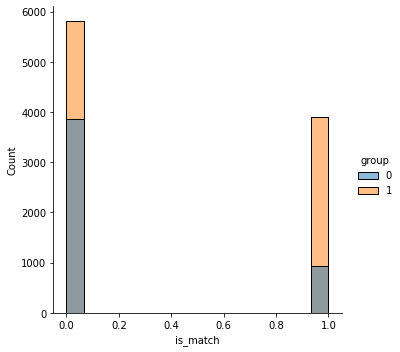

In [119]:
sns.displot(data=df, x=df.is_match, hue = df.group)

Изучим данные и проверим, сколько у каждого пользователя мэтчей и кликов, и как это выглядит в среднем в разрезе по исследуемым группам

In [120]:
df['click'] = 1 

In [121]:
df2 = df.groupby(["user_id_1", "group"],as_index = False).agg({"is_match" : "sum", "click" : "count"})

In [122]:
df3 = df.groupby(["user_id_2", "group"],as_index = False).agg({"is_match" : "sum", "click" : "count"})

In [123]:
df4 = df2.merge(df3, left_on = "user_id_1", right_on = "user_id_2")

In [124]:
df4["is_match"] = df4.is_match_x + df4.is_match_y

In [125]:
df4["click"] = df4.click_x + df4.click_y

In [126]:
df4["procent_match"] = round(100*df4.is_match/df4.click, 2)

Для каждого пользователя получим его группу, количество мэтчей и кликов.
Выведем еще один показатель - процент мэтчей от кликов (аналогично конверсии)

In [127]:
df4[["user_id_1", "group_x", "is_match", "click", "procent_match"]]

,user_id_1,group_x,is_match,click,procent_match
0,1,1,16,37,43.24
1,2,1,16,39,41.03
2,3,1,8,25,32.00
3,4,0,3,17,17.65
4,5,1,18,34,52.94
...,...,...,...,...,...
995,996,0,2,14,14.29
996,997,0,1,26,3.85
997,998,1,18,36,50.00
998,999,0,3,20,15.00


Проверим количество пользователей в каждой группе и убедимся, что они практически равны

In [128]:
df4.groupby("group_x").agg({"user_id_1" : "count"})

,user_id_1
group_x,
0,501
1,499


Из данных мы видим, что в среднем пользователи 1-ой группы чаще мэтчат, кликают, и имеют более чем в два раза больше процент мэтчей.
Но это не говорит о стат значимых различиях между исследуемыми группами.

In [129]:
df4.groupby("group_x").agg({"is_match" : "mean", "click" : "mean", "procent_match" : "mean"})

,is_match,click,procent_match
group_x,,,
0,3.728543,19.129741,19.354970
1,15.667335,38.965932,40.227194


Выберем метрику ключевую для нас метрику- количество мэтчей. Чем мэтчей больше - тем более эффективно работает наше приложение, для чего и был создан новый алгоритм.
Тогда сформулируем следующую нулевую гипотезу H0: Новый алгоритм не увеличил кол-во мэтчей

In [130]:
df

,user_id_1,user_id_2,group,is_match,click
0,79,91,1,1,1
1,716,353,1,1,1
2,423,677,0,0,1
3,658,165,1,1,1
4,969,155,0,1,1
...,...,...,...,...,...
14509,476,631,0,0,1
14510,455,770,1,0,1
14511,260,6,1,1,1
14512,885,812,1,1,1


Сгруппируем данные по группам и посчитаем кол-во мэтчей и всего кол-во кликов

In [131]:
df_1 = df.groupby('group').agg({'is_match' : 'sum', 'click' : 'count'})

In [132]:
df_1

,is_match,click
group,,
0,934,4792
1,3909,9722


Посчитаем кол-во дизлайков в каждой группе

In [133]:
df_1['not_match'] = df_1.click - df_1.is_match

In [134]:
df_1 = df_1[['is_match', 'not_match']]

In [135]:
df_1

,is_match,not_match
group,,
0,934,3858
1,3909,5813


Применем Хи-квадрат Пирсона и получим p-value < 0.05, что означает, что мы можем отклонить Н0, а это значит, 
что тестовый алгоритм статистически значимо увеличил нашу целевую метрику. 
А это означает, что сделанные выводы в процессе изучения данных о кратном увеличении количества мэтчей и процента мэтчей к кликам (конверсия) не являются выбросами.
Новый алгоритм стоит распространить на всех пользователей приложением.

In [136]:
scipy.stats.chi2_contingency(df_1)

(618.6889141576198,
 1.4418299163662586e-136,
 1,
 array([[1598.98415323, 3193.01584677],
        [3244.01584677, 6477.98415323]]))